# Imports and Files

In [8]:
# Dependencies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import ADASYN # SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import lime
import lime.lime_tabular
from lime import submodular_pick
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # 'default'

In [9]:
# Read CSV files as dataframes
injuries_df = pd.read_csv('InjuryRecord.csv')
players_df = pd.read_csv('PlayerTrackData.csv')
plays_df = pd.read_csv('PlayList.csv')

# Display dataframes
#for df in [injuries_df, players_df, plays_df]:
    #print(len(df))
    #print(df.columns)
    #print(df)

# Injured Player Track Dataframe Construction

In [ ]:
# Merge data from injuries csv onto player track csv
injured_players_df = players_df[(players_df['PlayKey'].isin(list(injuries_df['PlayKey']))) & (players_df['PlayKey'].isin(list(plays_df['PlayKey'])))]
for f in ["PlayerKey", "GameID", "BodyPart", "Surface", "DM_M1", "DM_M7", "DM_M28", "DM_M42"]:
    for key in np.unique(injured_players_df['PlayKey']):
        injured_players_df.loc[injured_players_df['PlayKey'] == key, f] = [injuries_df.loc[injuries_df['PlayKey'] == key, f].iloc[0]] * len(injured_players_df.loc[injured_players_df['PlayKey'] == key])

# Merge data from plays csv onto player track csv
for f in ["RosterPosition", "StadiumType", "FieldType", "Weather", "PlayType", "Position", "PositionGroup", "PlayerDay", "PlayerGame", "Temperature", "PlayerGamePlay"]:
    for key in np.unique(injured_players_df['PlayKey']):
        injured_players_df.loc[injured_players_df['PlayKey'] == key, f] = [plays_df.loc[plays_df['PlayKey'] == key, f].iloc[0]] * len(injured_players_df.loc[injured_players_df['PlayKey'] == key])

# Make datatypes consistent on 'event' field
injured_players_df['event'] = [str(e) for e in injured_players_df['event']]

# Injury Plays and Categorical Encodings

In [26]:
# Create injury plays dataframe
inj_plays_df = plays_df.copy()
inj_plays_df['INJ'] = [key in list(injuries_df['PlayKey']) for key in inj_plays_df['PlayKey']]

In [27]:
# Categorical encoding fields
categoricals = ['RosterPosition','StadiumType','FieldType','Weather','PlayType','Position','PositionGroup']

# Stadium type data corrections
INDOOR = ['Closed Dome', 'Dome', 'Dome, closed', 'Domed', 'Domed, closed', 'Indoor', 'Indoor, Roof Closed', 
          'Indoors', 'Retr. Roof - Closed', 'Retr. Roof Closed', 'Retr. Roof-Closed']
OUTDOOR = ['Bowl', 'Cloudy', 'Domed, Open', 'Domed, open', 'Heinz Field', 'Indoor, Open Roof', 'Open',
           'Oudoor', 'Ourdoor', 'Outddors', 'Outdoor', 'Outdoor Retr Roof-Open', 'Outdoors', 'Outdor', 
           'Outside', 'Retr. Roof - Open', 'Retr. Roof-Open', 'Retractable Roof']
inj_plays_df['StadiumType'] = ['Indoor' if k in INDOOR 
                               else 'Outdoor' if k in OUTDOOR 
                               else 'NAN' for k in inj_plays_df['StadiumType']]
inj_plays_df = inj_plays_df[inj_plays_df['StadiumType'] != 'NAN']

# Weather data corrections
CLEAR = ['Clear','Clear Skies','Clear and Cool','Clear and Sunny','Clear and cold','Clear and sunny',
         'Clear and warm', 'Clear skies', 'Clear to Partly Cloudy', 'Cold', 'Fair', 'Heat Index 95',
         'Mostly Sunny', 'Mostly Sunny Skies', 'Mostly sunny', 'Partly Sunny', 'Partly clear',
         'Partly sunny', 'Sun & clouds', 'Sunny', 'Sunny Skies', 'Sunny and clear', 'Sunny and cold',
         'Sunny and warm', 'Sunny, Windy', 'Sunny, highs to upper 80s']
RAIN = ['10% Chance of Rain', '30% Chance of Rain', 'Showers',
        'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
        'Cloudy, 50% change of rain', 'Cloudy, Rain', 'Cloudy, chance of rain', 'Light Rain', 'Rain',
        'Rain Chance 40%', 'Rain likely, temps in low 40s.', 'Rain shower', 'Rainy', 'Scattered Showers']
CLOUDS = ['Cloudy', 'Cloudy and Cool', 'Cloudy and cold', 'Cloudy, fog started developing in 2nd quarter',
          'Coudy', 'Hazy', 'Mostly Cloudy', 'Mostly Coudy', 'Mostly cloudy', 'Overcast', 'Partly Cloudy',
          'Partly Clouidy', 'Partly cloudy', 'Party Cloudy', 'cloudy']
SNOW = ['Cloudy, light snow accumulating 1-3"', 'Heavy lake effect snow', 'Snow']
INDOORS = ['Controlled Climate', 'Indoor', 'Indoors', 'N/A (Indoors)', 'N/A Indoor']
inj_plays_df['Weather'] = ['Clear' if k in CLEAR 
                           else 'Rain' if k in RAIN
                           else 'Clouds' if k in CLOUDS
                           else 'Snow' if k in SNOW
                           else 'Indoor' if k in INDOORS
                           else 'NAN' for k in inj_plays_df['Weather']]
inj_plays_df = inj_plays_df[inj_plays_df['Weather'] != 'NAN']

# Play type data corrections
PUNT = ['Punt', 'Punt Returned', 'Punt Not Returned']
KICKOFF = ['Kickoff', 'Kickoff Returned', 'Kickoff Not Returned']
inj_plays_df['PlayType'] = ['Punt' if k in PUNT 
                            else 'Kickoff' if k in KICKOFF
                            else k for k in inj_plays_df['PlayType']]

# Removal of remaining null data
inj_plays_df = inj_plays_df[inj_plays_df['PlayType'] != '0']
inj_plays_df = inj_plays_df[inj_plays_df['Position'] != 'Missing Data']
inj_plays_df = inj_plays_df[inj_plays_df['PositionGroup'] != 'Missing Data']
inj_plays_df = inj_plays_df[inj_plays_df['PlayerDay'] != np.nan]
inj_plays_df = inj_plays_df[inj_plays_df['PlayerGame'] != np.nan]
inj_plays_df = inj_plays_df[inj_plays_df['PlayerGamePlay'] != np.nan]
inj_plays_df = inj_plays_df[inj_plays_df['Temperature'] != np.nan]

In [31]:
# Build encodings
categoricals_map = {}
for c in categoricals:
    categoricals_map[c] = {n:i for i, n in enumerate(np.unique([str(item) for item in inj_plays_df[c]]))}
    inj_plays_df[c] = [categoricals_map[c][str(n)] for n in inj_plays_df[c]]
    print(categoricals_map[c])
    
# ONE HOT ENCODING METHOD
#from sklearn.preprocessing import OneHotEncoder
#import numpy as np
#ohe = OneHotEncoder()
#for c in categoricals:
#   ohe.fit(np.array(inj_plays_df[c]).reshape(-1, 1))
#    inj_plays_df[c] = ohe.transform(np.array(inj_plays_df[c]).reshape(-1, 1)).todense()

{'Cornerback': 0, 'Defensive Lineman': 1, 'Kicker': 2, 'Linebacker': 3, 'Offensive Lineman': 4, 'Quarterback': 5, 'Running Back': 6, 'Safety': 7, 'Tight End': 8, 'Wide Receiver': 9}
{'Indoor': 0, 'Outdoor': 1}
{'Natural': 0, 'Synthetic': 1}
{'Clear': 0, 'Clouds': 1, 'Indoor': 2, 'Rain': 3, 'Snow': 4}
{'Extra Point': 0, 'Field Goal': 1, 'Kickoff': 2, 'Pass': 3, 'Punt': 4, 'Rush': 5, 'nan': 6}
{'C': 0, 'CB': 1, 'DB': 2, 'DE': 3, 'DT': 4, 'FS': 5, 'G': 6, 'HB': 7, 'ILB': 8, 'K': 9, 'LB': 10, 'MLB': 11, 'NT': 12, 'OLB': 13, 'P': 14, 'QB': 15, 'RB': 16, 'S': 17, 'SS': 18, 'T': 19, 'TE': 20, 'WR': 21}
{'DB': 0, 'DL': 1, 'LB': 2, 'OL': 3, 'QB': 4, 'RB': 5, 'SPEC': 6, 'TE': 7, 'WR': 8}


# Logistic Regression

In [154]:
# Scikit Learn logistic regression model feature selection
feature_cols = ['RosterPosition', 'PlayerDay', 'StadiumType','FieldType','Temperature','Weather','PlayType','PlayerGamePlay','Position','PositionGroup'] #'PlayerGame',
X = inj_plays_df[feature_cols]
y = inj_plays_df['INJ']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

## SMOTE oversampling
#sm = SMOTE(random_state=42)
#X_smote, y_smote = sm.fit_resample(X_train, y_train)

# ADASYN oversampling
ada = ADASYN(random_state=42, sampling_strategy=.5)
X_train, y_train = ada.fit_resample(X, y)

# Random undersampling
rus = RandomUnderSampler(random_state=0, sampling_strategy=.75)
X_train, y_train = rus.fit_resample(X_train, y_train)

In [44]:
# Build and train model 
logreg = LogisticRegression(random_state=16, max_iter=1000000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [12]:
print(X_train)

        RosterPosition  PlayerDay  PlayerGame  StadiumType  FieldType  \
44006              0.0         56           8          0.0        1.0   
247331             0.0        407          22          0.0        1.0   
187590             0.0        400          22          0.0        1.0   
179253             0.0        420          24          0.0        0.0   
32673              0.0        109          15          0.0        0.0   
...                ...        ...         ...          ...        ...   
202848             0.0        428          20          0.0        0.0   
87479              0.0         64           9          0.0        0.0   
188806             0.0         71          10          0.0        1.0   
255104             0.0         71           8          0.0        1.0   
105735             0.0         63           9          0.0        0.0   

        Temperature  Weather  PlayType  PlayerGamePlay  Position  \
44006            61      0.0       0.0              10 

Text(0.5, 427.9555555555555, 'Predicted')

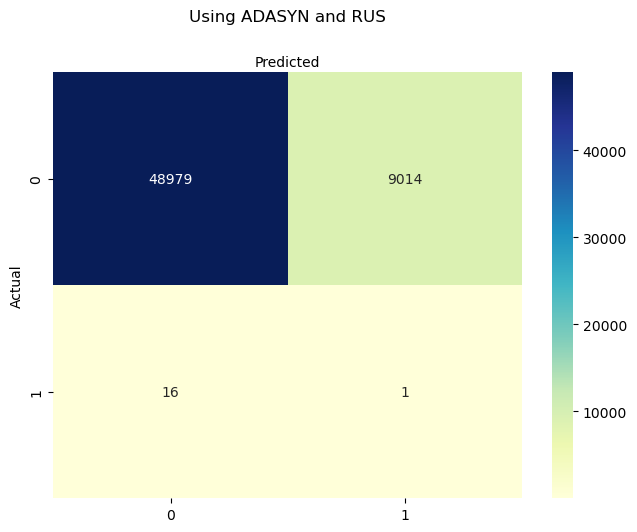

In [135]:
# Build confusion matrix and display
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=['No Injury', 'Injury'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Using ADASYN and RUS', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Neural Network

In [38]:
# THIS CELL IS A COPY OF A CELL ABOVE FOR CONVENIENCE

# Scikit Learn logistic regression model feature selection
feature_cols = ['RosterPosition', 'PlayerDay', 'StadiumType','FieldType','Temperature','Weather','PlayType','PlayerGamePlay','Position','PositionGroup'] #'PlayerGame',
X = inj_plays_df[feature_cols]
y = inj_plays_df['INJ']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

## SMOTE oversampling
#sm = SMOTE(random_state=42)
#X_smote, y_smote = sm.fit_resample(X_train, y_train)

# ADASYN oversampling
ada = ADASYN(random_state=42, sampling_strategy=.5)
X_train, y_train = ada.fit_resample(X, y)

# Random undersampling
rus = RandomUnderSampler(random_state=0, sampling_strategy=.75)
X_train, y_train = rus.fit_resample(X_train, y_train)

In [39]:
# Create MLP classifier
mlp = MLPClassifier()
clf = MLPClassifier(
    activation='relu',
    learning_rate='adaptive',
    solver='adam',
    alpha=0.005,
    hidden_layer_sizes=(25, 15, 9, 4),
    random_state=1
)

# Define hyperparameters of interest
parameter_space = {
    'hidden_layer_sizes': [
        (100, 81, 64, 49, 36, 25, 16, 9, 4),
        (100, 95, 90, 85, 80, 75, 70, 65, 60, 55, 50, 45, 40, 35, 30, 25, 20, 15, 10, 5)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [.002, .0016, .0012, .0008, .0004],
    'learning_rate': ['adaptive'],
}

# Conduct grid search
#clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3, scoring='balanced_accuracy')

# Fit
clf.fit(X_train, y_train)

# Output best parameter set
#print('Best parameters found:\n', clf.best_params_)

# Output all results
#means = clf.cv_results_['mean_test_score']
#stds = clf.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#   print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
# Make prediction
y_pred = clf.predict(X_test)

Text(0.5, 23.52222222222222, 'Predicted')

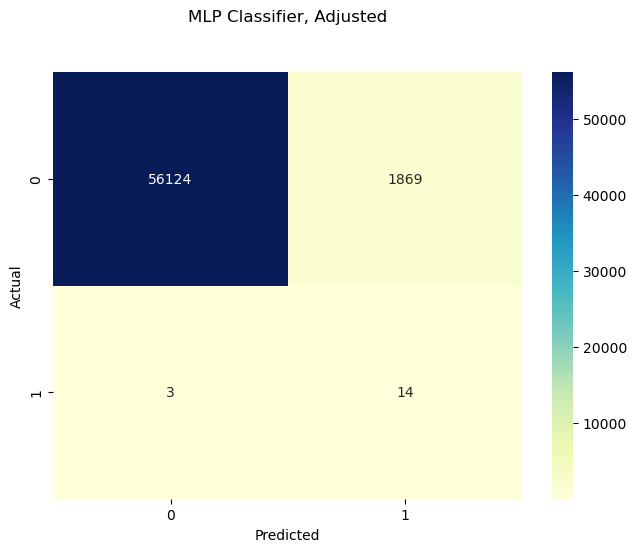

In [40]:
# Build confusion matrix and display
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=['No Injury', 'Injury'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('MLP Classifier, Adjusted', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

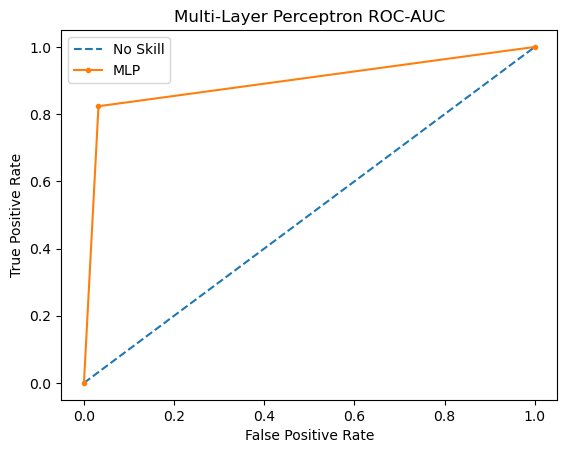

In [41]:
# Precision-Recall curve and AUC-ROC curve
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
mlp_fpr, mlp_tpr, _ = metrics.roc_curve(y_test, y_pred)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(mlp_fpr, mlp_tpr, marker='.', label='MLP')

plt.title('Multi-Layer Perceptron ROC-AUC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

# Metrics

In [42]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)

Accuracy: 0.967730
Precision: 0.007435
Recall: 0.823529
F1 score: 0.014737
ROC AUC: 0.895651


##### Old Figures
Accuracy: 0.971005

Precision: 0.008870

Recall: 0.714286

F1 score: 0.017523

ROC AUC: 0.842692

##### Once Refined

Accuracy: 0.977607

Precision: 0.013699

Recall: 0.857143

F1 score: 0.026966

ROC AUC: 0.917397

# Random Forest?

In [335]:
# THIS IS A COPY OF A CELL FROM ABOVE FOR CONVENIENCE

# Scikit Learn logistic regression model feature selection
feature_cols = ['RosterPosition', 'PlayerDay', 'PlayerGame', 'StadiumType','FieldType','Temperature','Weather','PlayType','PlayerGamePlay','Position','PositionGroup']
X = inj_plays_df[feature_cols]
y = inj_plays_df['INJ']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

## SMOTE oversampling
#sm = SMOTE(random_state=42)
#X_smote, y_smote = sm.fit_resample(X_train, y_train)

# ADASYN oversampling
#ada = ADASYN(random_state=42, sampling_strategy=.2)
#X_train, y_train = ada.fit_resample(X_train, y_train)

# Random undersampling
rus = RandomUnderSampler(sampling_strategy=.5)
X_train, y_train = rus.fit_resample(X_train, y_train)

In [336]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()

# Define hyperparameters of interest
parameter_space = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}

# Conduct grid search
clf = GridSearchCV(forest, parameter_space, n_jobs=-1, cv=3, scoring='balanced_accuracy')
clf.fit(X_train, y_train)

# Output best parameter set
print('Best parameters found:\n', clf.best_params_)

# Predict
y_pred = clf.predict(X_test)

#Best parameters found:
#{'bootstrap': True, 'max_depth': 80, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
#{'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1200}

Best parameters found:
 {'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1200}


Text(0.5, 23.52222222222222, 'Predicted')

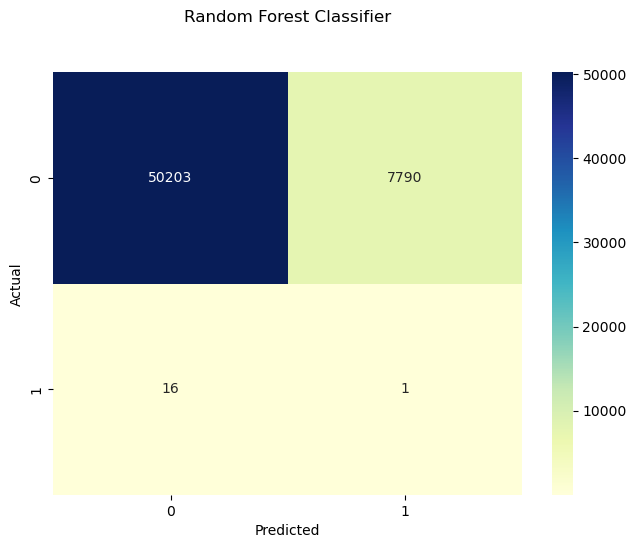

In [337]:
# Build confusion matrix and display
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=['No Injury', 'Injury'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Random Forest Classifier', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

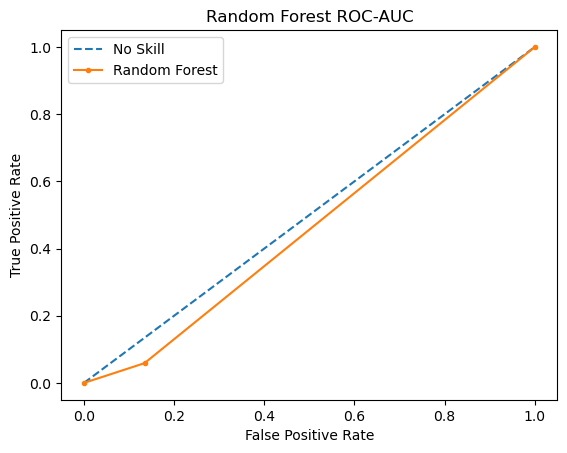

In [338]:
# Precision-Recall curve and AUC-ROC curve
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
mlp_fpr, mlp_tpr, _ = metrics.roc_curve(y_test, y_pred)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(mlp_fpr, mlp_tpr, marker='.', label='Random Forest')

plt.title('Random Forest ROC-AUC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

In [334]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)

Accuracy: 0.803017
Precision: 0.000263
Recall: 0.176471
F1 score: 0.000525
ROC AUC: 0.489835


# Feature Importance

In [43]:
# LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(),
                                                  class_names=['INJ'], verbose=True, mode='regression')

In [44]:
# Choose the 5th instance and use it to predict the results
#for j in range(0, len(X_test.values), 1000):
#    print(f'Explanations for {j}th Instance')
#    exp = explainer.explain_instance(X_test.values[j], clf.predict)
#    exp.show_in_notebook(show_table=True)
#    print(exp.as_list())
#    fig = exp.as_pyplot_figure()

Intercept 0.08025487464872434
Prediction_local [0.04905463]
Right: False
Intercept 0.03271076875668814
Prediction_local [0.12967722]
Right: True
Intercept 0.05699916990649714
Prediction_local [0.05748169]
Right: False
Intercept 0.06839097862634458
Prediction_local [-0.01901862]
Right: False
Intercept 0.07200195070297266
Prediction_local [0.04841156]
Right: False
Intercept 0.07191615492728275
Prediction_local [0.0496087]
Right: False
Intercept 0.06961331916115515
Prediction_local [0.05923074]
Right: False
Intercept 0.03884684825542851
Prediction_local [0.07142005]
Right: False
Intercept 0.030115405076904404
Prediction_local [0.09811409]
Right: False
Intercept 0.03218845510436875
Prediction_local [0.10559375]
Right: True
Intercept 0.03572768019527552
Prediction_local [0.05782941]
Right: False
Intercept 0.07629037939184047
Prediction_local [0.01486687]
Right: False
Intercept 0.02206519239445353
Prediction_local [0.10432154]
Right: True
Intercept 0.025531968795588403
Prediction_local [0.11

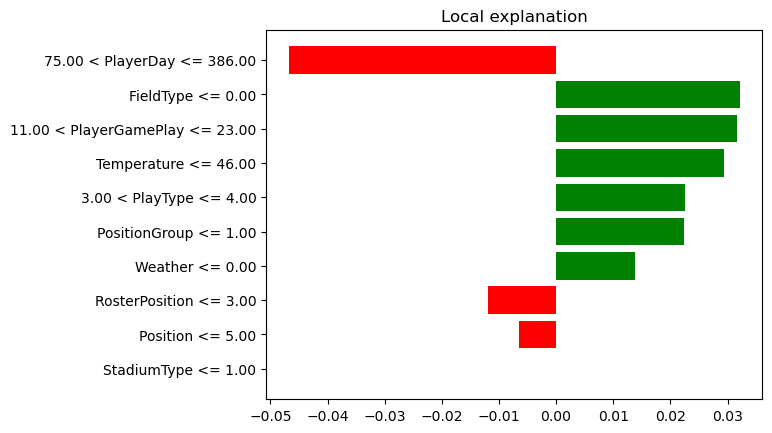

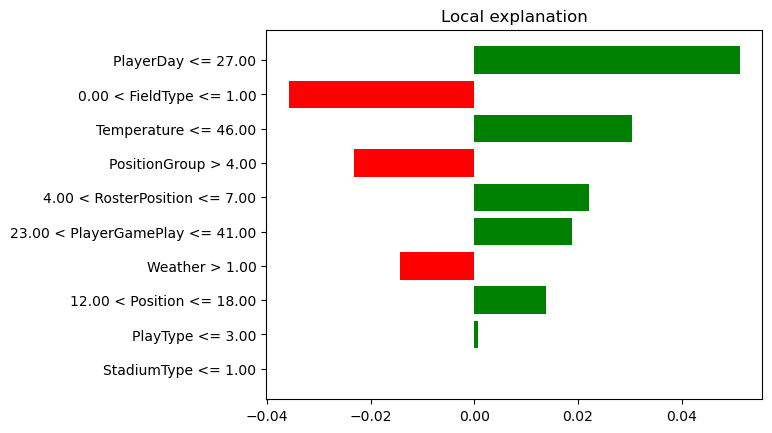

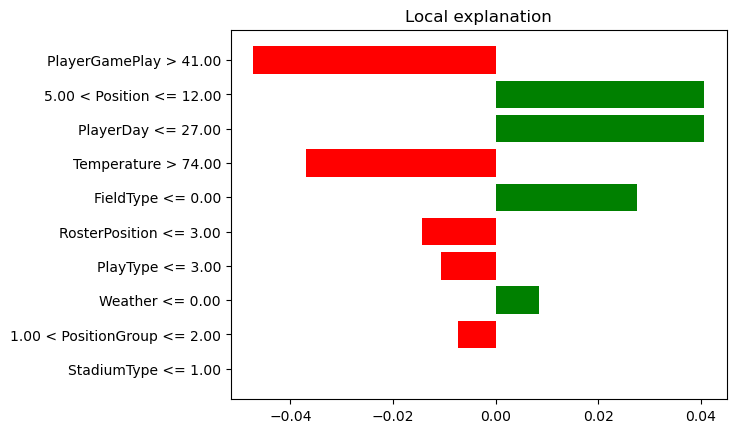

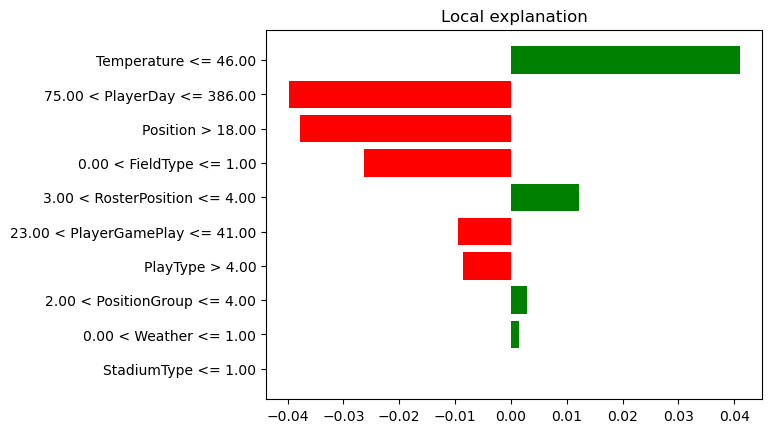

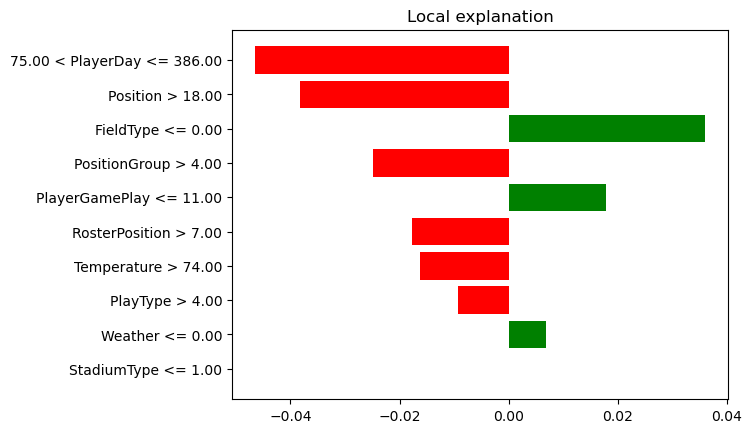

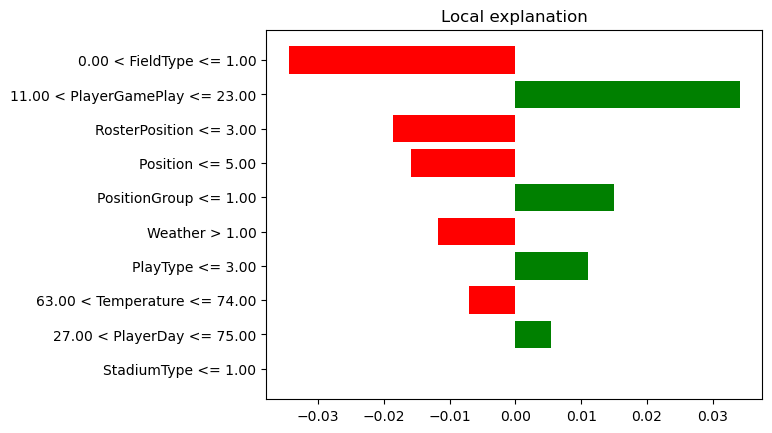

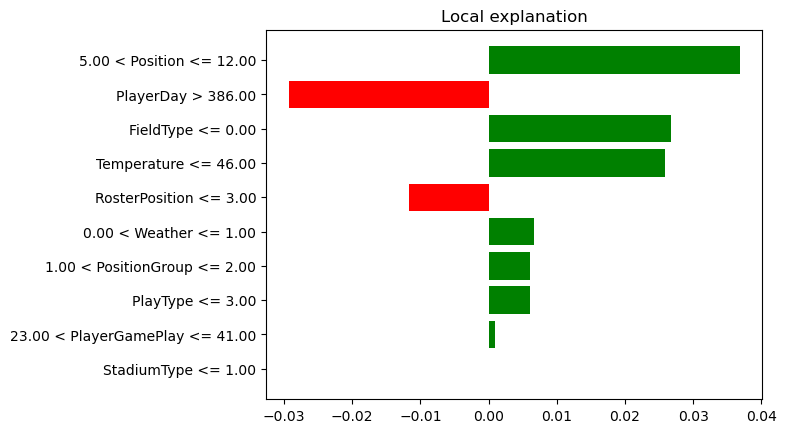

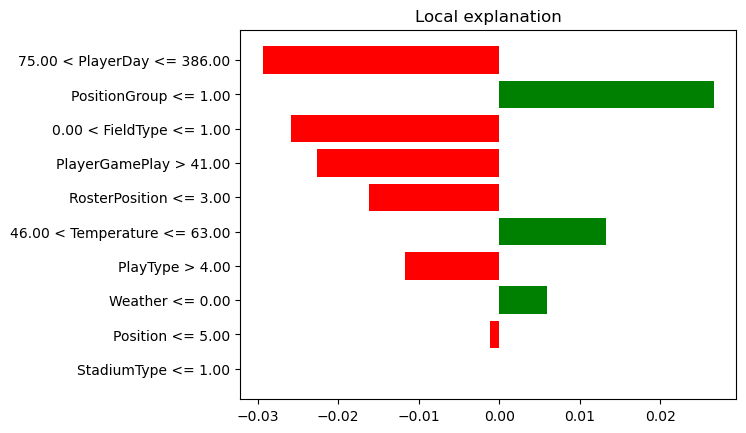

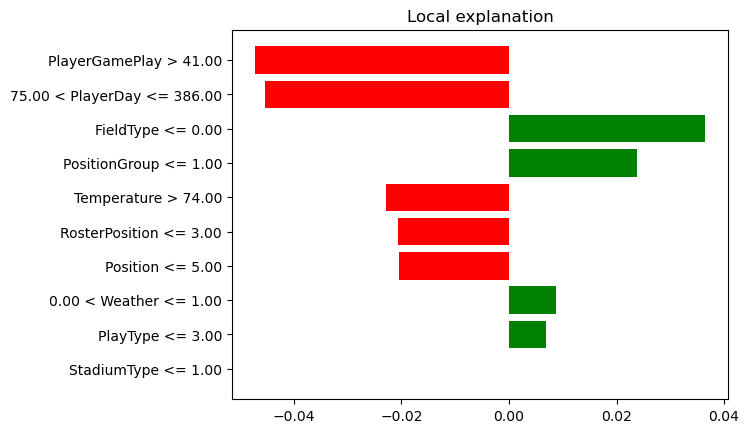

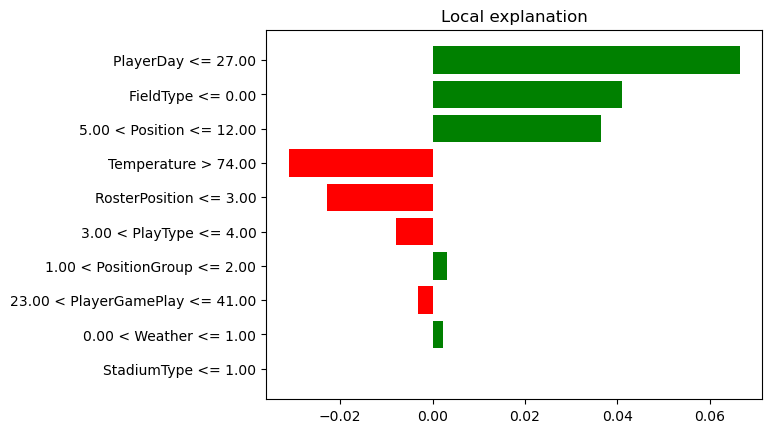

In [46]:
# SP-LIME best explanations
sp = submodular_pick.SubmodularPick(explainer, X_train.values, clf.predict, sample_size=20, num_exps_desired=10)
for exp in sp.sp_explanations:
    fig = exp.as_pyplot_figure() 
    fig.show()